In [1]:
# For reloading modules
import importlib

# My modules config has to be imported first
import config as cfg
import datasets
import utils
import models
import train

import display as disp

import time
import tensorflow as tf
import numpy as np

# Video and visualization stuff
import tqdm
import PIL.Image, PIL.ImageDraw

from IPython.display import Image, HTML, clear_output, Video
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
from visdom import Visdom

In [73]:
# Reload modules
importlib.reload(utils)
importlib.reload(models)
importlib.reload(datasets)
importlib.reload(cfg)
importlib.reload(train)
importlib.reload(disp)

<module 'display' from '/home/maxi/Documents/UNI/Thesis/dev/SoS/display.py'>

In [2]:
# Load Dataset & Model & Trainer
(x_train, y_train), (x_test, y_test) = datasets.get_data()
ca = models.CAModel()

# In order to use visdom, visdom.sh has to be executed
vis = Visdom()
trainer = train.Trainer(x_train, y_train, ca, vis)
utils.save_cfg()
ca.summary()
print(utils.get_cfg_infos())

(50, 50, 4)


Setting up a new session...


Successfully saved configs at:  logs/maybe/2020_11_10/16_14_09/
Model: "perceive"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 128)       18560     
Total params: 18,560
Trainable params: 18,560
Non-trainable params: 0
_________________________________________________________________
perceive:  None
------------
Model: "dmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50, 50, 128)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 16)        2064      
Total params: 2,064
Trainable params: 2,064
Non-trainable params: 0
_________________________________________________________________
dmodel:  None
{'TASK': {'TASK': 'growing', 'TARGET': 'double_exclamation_ma

In [3]:
NUM_RUNS = 1
NUM_TRAINING_STEPS = 2000

# tf.keras.backend.clear_session()
for e in range(NUM_RUNS):
  ca = models.CAModel()
  trainer = train.Trainer(x_train, y_train, ca, vis)
  
  for i in range(1, NUM_TRAINING_STEPS+1):
    x, x0, losses = trainer.full_train_step()
    trainer.visualize(x, x0, losses, e)
  
  plot = disp.plot_losses(trainer.loss_log, return_plot=True, title_text=utils.get_cfg_infos())
  utils.save_fig(plot, name=f"fig_{e}", as_img=False)


 r: 0 step: 2000, full_loss: 9.258

In [15]:
importlib.reload(disp)
plot = disp.plot_losses(trainer.loss_log, return_plot=True, title_text=utils.get_cfg_infos())
plot
# utils.save_json(plotly.io.to_json(plot))
# utils.save_fig(plot, as_img=True)
# vis.plotlyplot(plot) # , env="present")

In [47]:
import json
import requests

with open(cfg.EXTRA.LOG_PATH + cfg.EXTRA.SESSION_ID + "/diff.json") as f:
  # TODO not the same as the other plot title and not as pretty
  title = f.read()

# print(requests.get("""{"EXTRA":{"SESSION_ID": "2020_11_10/13_47_48"}}""").json)
full_str = ""
for i in range(len(title.split("\n"))):
  full_str += title.split("\n")[i][9:-1]
  # cur_dict = json.loads(title.split("\n")[i])
  # for key in cur_dict.keys():
  #   full_str += str(cur_dict[key])

print(full_str)


{}{"SKIP_CONNECTIONS": false, "HIDDEN_LAYERS": 1}{"POOL_TANH": true, "POOL_SIZE": 80, "MUTATE_POOL": false, "FIXED_SEED_RATIO": 0.125}{"SESSION_ID": "2020_11_10/13_47_48"}


In [27]:
# importlib.reload(utils)
importlib.reload(disp)
# sess_id = "2020_11_10/11_42_17"
sess_id = cfg.EXTRA.SESSION_ID
fig = disp.plot_avg_session(sess_id)
# fig.update_yaxes(type="log")
vis.plotlyplot(fig)
fig.show()


In [4]:
x = trainer.x_train[0:1]
y = trainer.y_train[0]


def test_emoji(x, y):
  loss_arr = []
  for i in range(cfg.WORLD.CA_STEP_RANGE[1] + 100):
    loss = trainer.individual_l2_loss(x,y)
    loss_arr.append(loss)
    x = trainer.ca(x)

  # fig = disp.plot_loss(np.array(loss_arr)[:,0], plot_mean=False, return_plot=True)
  fig = go.Figure(go.Scatter(y=np.array(np.array(loss_arr)[:,0])))
  return fig
  
fig = test_emoji(x, y)
fig.layout.title.text = "Testing performance"
fig
# vis.plotlyplot(fig)

In [125]:
weights_0 = trainer.ca.perceive.weights[0].numpy()
print(np.amax(weights_0))
print(np.amin(weights_0))
print(np.mean(weights_0))
print(np.std(weights_0))

weights_1 = trainer.ca.perceive.weights[1].numpy()

w = trainer.ca.dmodel.weights
print(w[0].shape)
# assert False
print(w[0].shape, w[1].shape)
# def get_weight_info(weights):
# plt.bar(np.arange(len(weights_1)), weights_1)
# plt.hist(weights_1)
# plt.show()
# import plotly.express as px
# fig = px.histogram(weights_1)
# fig.show()

fig = px.histogram(w[0].numpy().flatten(), title="dmodel_l_0, 0 steps")
vis.plotlyplot(fig)

0.068040445
-0.06803571
-4.065325e-05
0.039368298
(1, 1, 128, 128)
(1, 1, 128, 128) (128,)


'window_3901a1893337de'

In [7]:
# ---- VIDEO -----

# Bigger padding around img (cfg.WORLD.SIZE for standard size)
x_big = datasets.add_padding(x_train[0], cfg.WORLD.SIZE)[None, :]

# Cut random box from imgae
x_cut = trainer.cut_x(trainer.pool_t[:8])[0:1]

# Create and show video
disp.show_simple_run(x_big, trainer.ca, cfg.WORLD.CA_STEP_RANGE[0] + 150 , only_alive_cells=False)
# vis.video(videofile="./_autoplay.mp4")

(50, 50, 16)


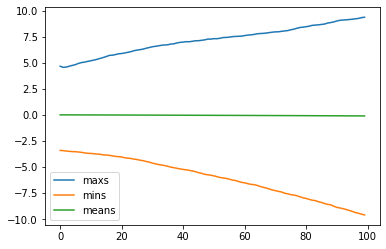

In [52]:
maxs = []
mins = []
means= []

# x_all,y = trainer.get_new_emoji_x_y()
x = x_all[1:2]
for i in range(100):
  maxs.append(np.amax(x))
  mins.append(np.amin(x))
  means.append(np.mean(x))
  x = trainer.ca(x)
  
plt.plot(maxs, label="maxs")
plt.plot(mins, label="mins")
plt.plot(means, label="means")
plt.legend()
plt.show()

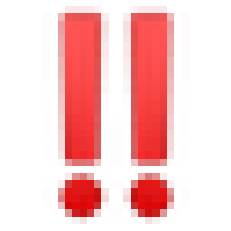

In [61]:
importlib.reload(datasets)
e = datasets.Emoji("double_exclamation_mark")
e.show_emoji()

get_new_x_y
mean: 0.0008771225116800343


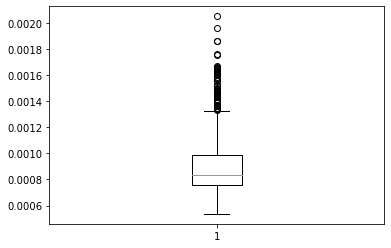

full_train_step
mean: 0.0853380825353778


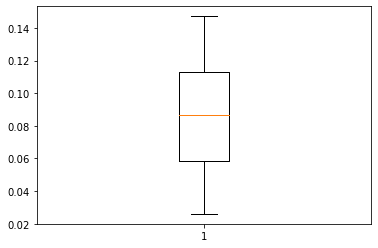

visualize
mean: 0.0022452206776224417


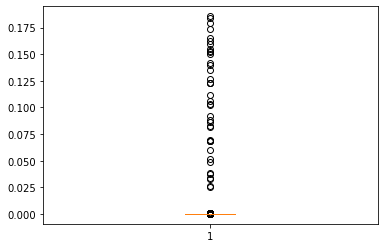

In [18]:
# Show execution times as boxplots
for key in utils.total_time_dict.keys():
  print(key)
  print("mean:", np.mean(utils.total_time_dict[key][1:]))
  # Removing the first as most time too long and not representative
  plt.boxplot(utils.total_time_dict[key][1:])
  plt.show()

In [ ]:
# Load full save confgis
# all_c = utils.load_full_save("2020_11_03", "10_35_07")

In [ ]:
# TODO outsource
def eval_all(ca, num_steps, mutate):
  all_accuracies = []
  all_agreements = []

  # total test set is 10000
  num_batches = 10
  eval_bs = 10000 // num_batches
  for i in tqdm.trange(num_batches):
    x_set = x_test[eval_bs*i:eval_bs*(i+1)]
    y_set = y_test[eval_bs*i:eval_bs*(i+1)]
    acc_i, agr_i = models.eval_batch_fn(ca, x_set, y_set, num_steps, mutate)
    all_accuracies.append(acc_i)
    all_agreements.append(agr_i)

  all_accuracies = [sum(l)/num_batches for l in zip(*all_accuracies)]
  all_agreements = [sum(l)/num_batches for l in zip(*all_agreements)]
  return all_accuracies, all_agreements


In [ ]:
eval_batch = 1000
num_iters = 10

# TODO this takes ages!
start_time = time.time()
all_accuracies, all_agreements = eval_all(trainer.ca, num_steps=200, mutate=True)
print("All Acc time: ", time.time() - start_time)

plt.figure(figsize=(10, 4))
plt.title('Average cell accuracy over steps (%)')
plt.xlabel('Number of steps')
plt.ylabel('Average cell accuracy (%)')
plt.xlim(0, 400)
plt.ylim(0, 100)
plt.plot(all_accuracies, label="ca")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Average total agreement across batch over steps (%)')
plt.xlabel('Number of steps')
plt.ylabel('Average total agreement (%)')
plt.xlim(0, 400)
plt.ylim(0, 100)
plt.plot(all_agreements, label="ca")
plt.legend()

In [ ]:
importlib.reload(datasets)
importlib.reload(utils)
importlib.reload(cfg)
importlib.reload(models)

ca = models.CAModel()

# There is a way without plt, and with PIL, but this is easy for me
emoji = datasets.Emoji("lizard")
# utils.imshow(utils.zoom(emoji.emoji_img, 4))
# utils.imshow(utils.zoom(emoji.emoji_rgb, 4))
# emoji.show_emoji()
# print(datasets.init_seed().shape)

seed = datasets.init_seed()
# utils.imshow(utils.zoom(1 - datasets.init_seed()[0,:,:,:3], 4))
utils.imshow(1-utils.zoom(ca(ca(ca(seed)))[0,:,:,:3],4))

In [ ]:
ca.summary()

"""
eval_bs= 100
num_steps = 400 

ca = get_model(add_noise=False, loss_type='ce')
make_run_videos(ca, num_steps, eval_bs, "ce_runs", disable_black=True)
mvp.ipython_display('ce_runs.mp4')
"""

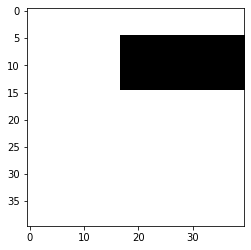

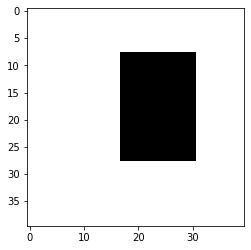

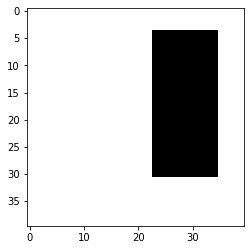

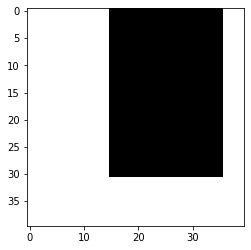

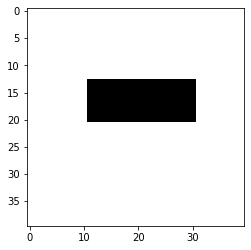

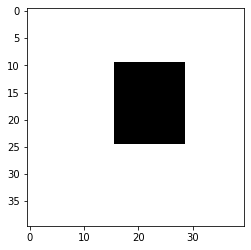

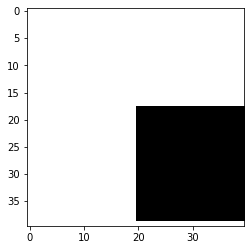

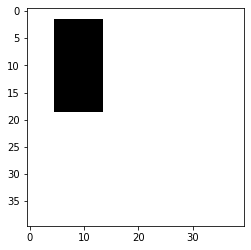

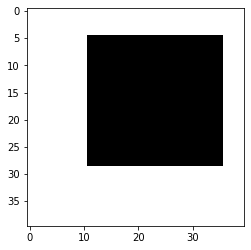

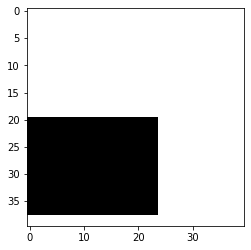

In [83]:
x = np.ones((40, 40, 3))

def cut_x(x):
  x = np.copy(x)
  # Assuming x is squared
  box_size_range_x = [x.shape[0]*0.2, x.shape[0]*0.8]
  box_size_range_y = [x.shape[1]*0.2, x.shape[1]*0.8]
  box_width = np.random.randint(*box_size_range_x)
  box_height = np.random.randint(*box_size_range_y)
  
  # Randomly select the middle coordinates of the box
  box_x_mid = np.random.randint(x.shape[0]*0.2, x.shape[0]*0.8)
  box_y_mid = np.random.randint(x.shape[1]*0.2, x.shape[1]*0.8)
  
  box_x = max(0, box_x_mid - int(box_width/2))
  box_y = max(0, box_y_mid - int(box_height/2))
  
  # check boundaries
  box_x_end = min(x.shape[0], box_x + box_width)
  box_y_end = min(x.shape[1], box_y + box_height)
  
  # apply cut
  x[box_x:box_x_end, box_y:box_y_end, :] = 0
  return x
  
# cut_x(x)
for i in range(10):
  plt.imshow(cut_x(x))
  plt.show()